# Project PCD 2025 Kelompok 18
## Klasifikasi Kangker Kulit Jinak Dan Ganas
Zainul Majdi (F1D02310028)

Mustofa Arif (F1D02310083)

Apriesna Zulhan (F1D02310100)

Lalu Maulana Rizki Hidayat (F1D02310118)

# Project Overview

# Import Library

In [179]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from collections import Counter

## Data Loading

In [180]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


# Membuat Diagram Batang

Jumlah data per kelas: Counter({np.str_('benign'): 360, np.str_('malignant'): 300})


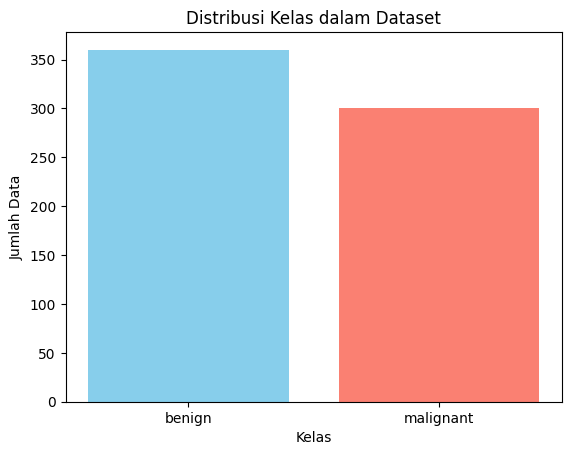

In [181]:
class_count = Counter(labels)

print("Jumlah data per kelas:", class_count)

label_names = list(class_count.keys())
jumlah = list(class_count.values())

plt.bar(label_names, jumlah, color=['skyblue', 'salmon'])
plt.title("Distribusi Kelas dalam Dataset")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.show()

## Data Preparation

### Define Preprocessing Function


In [182]:
def resize(img, new_width, new_height):
    h, w = img.shape
    resized = np.zeros((new_height, new_width), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            x = int(j * w / new_width)
            y = int(i * h / new_height)
            resized[i, j] = img[y, x]
    
    return resized

def normalize_min_max(image):
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val == min_val:
        return np.zeros_like(image, dtype=np.uint8)  
    norm = (image - min_val) / (max_val - min_val)
    return (norm * 255).astype(np.uint8)

def median_filter(image,baris,kolom):
    tengah = int(baris*kolom/2)
    hasil = np.zeros(image.shape)
    _baris = int((baris-1)/2)
    _kolom = int((kolom-1)/2)
    _image = np.pad(image,((_baris,_baris),(_kolom,_kolom)),mode='edge')
    for i in range (hasil.shape[0]):
        for j in range (hasil.shape[1]):
            Median = np.zeros(baris*kolom)
            m=0
            for k in range (i,i+baris):
                for l in range (j,j+kolom):
                    Median[m]=_image[k,l]
                    m+=1
            Median.sort()
            a = Median[tengah]
            b = Median[tengah-1]
            _Median = int(a+b)/2
            hasil[i,j] =_Median
    return hasil.astype(np.uint8)


### Preprocessing

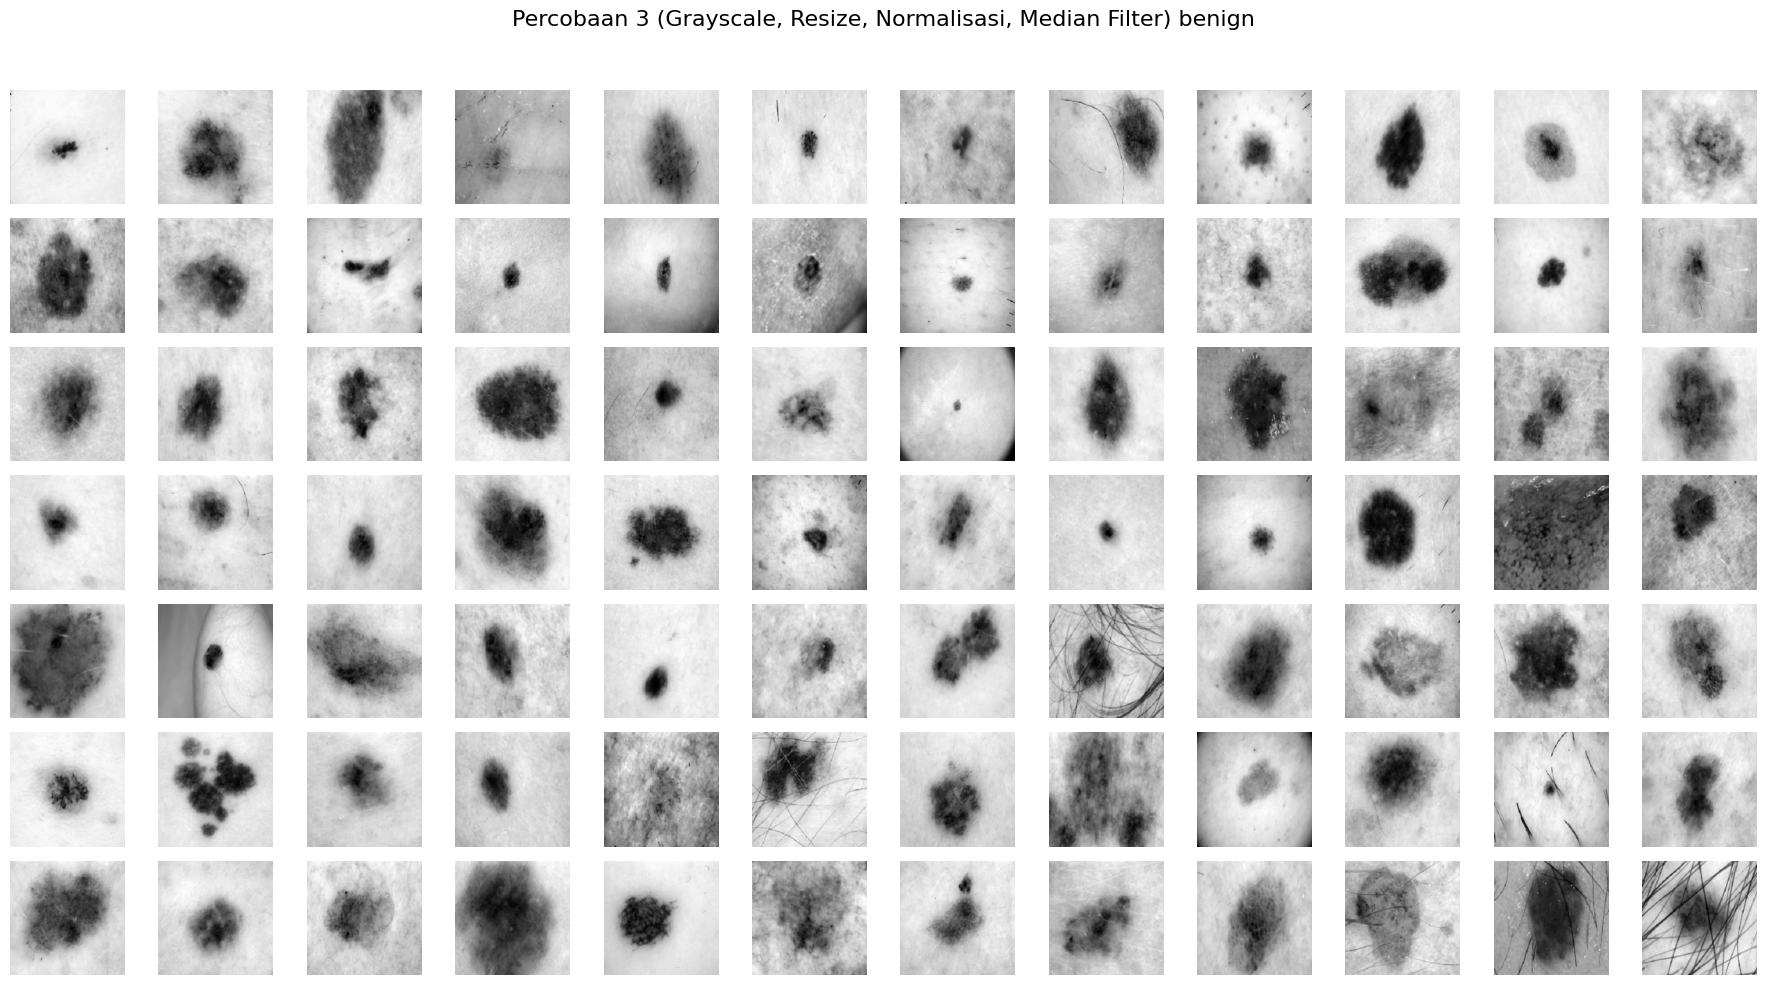

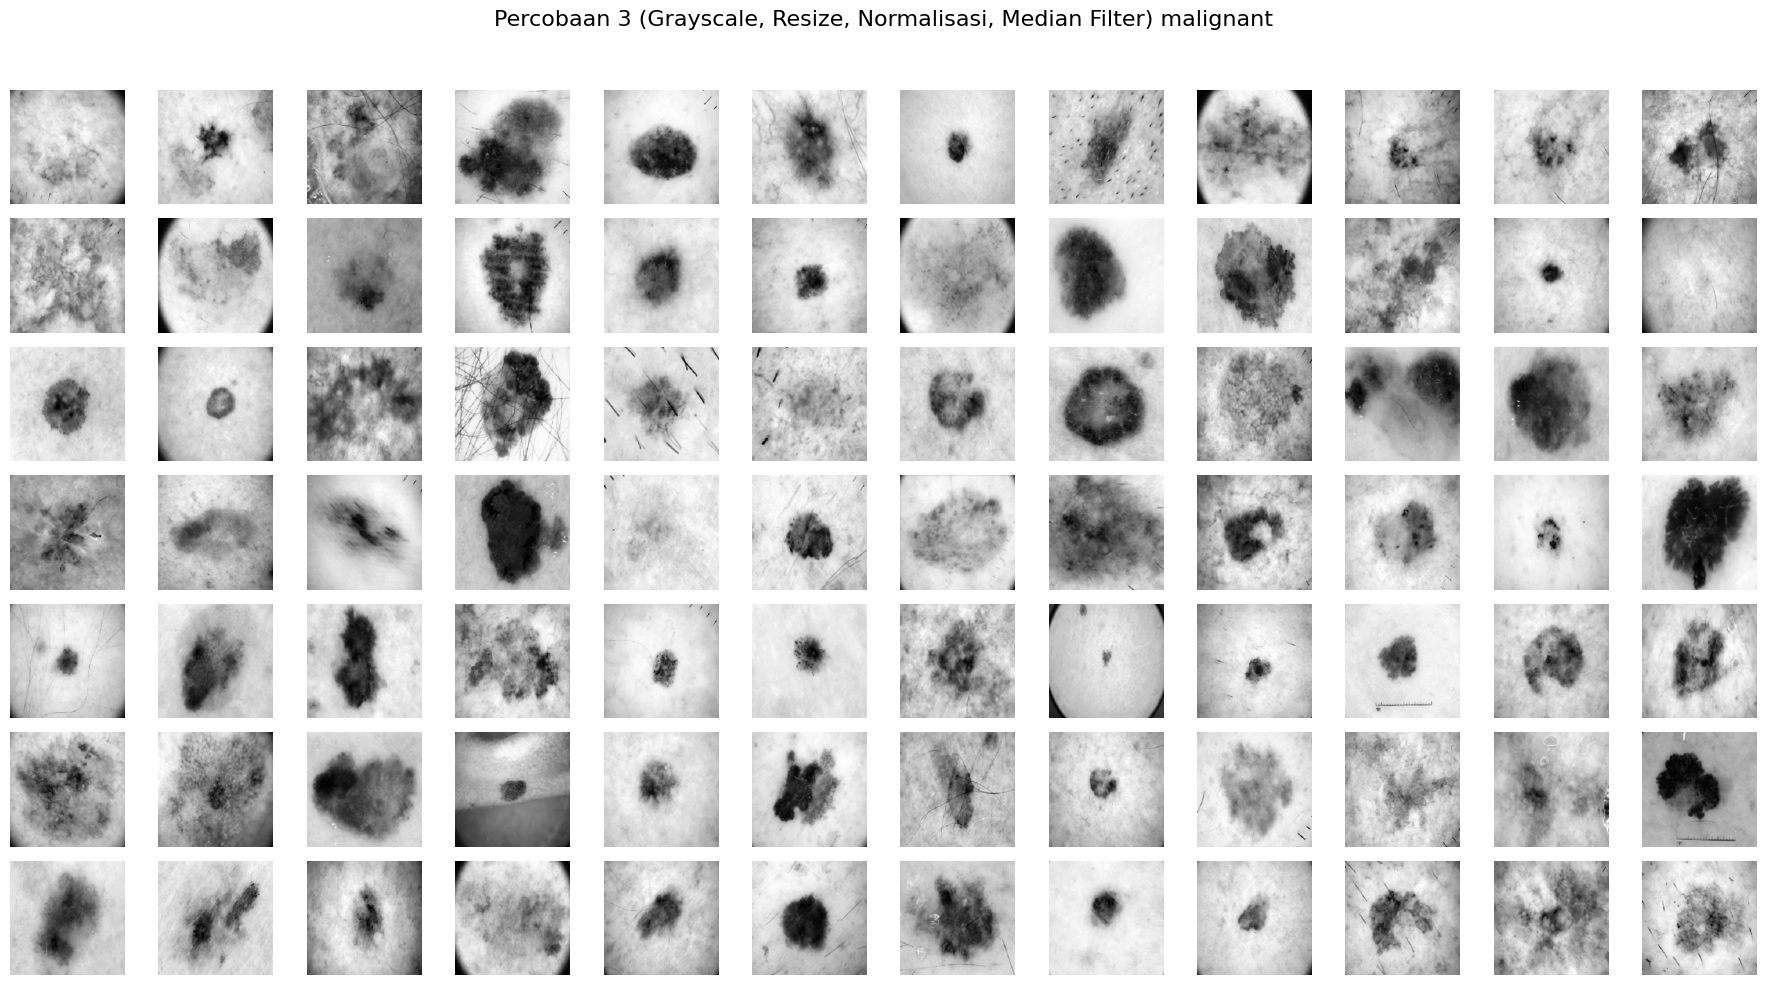

In [183]:
def percobaan_3(img):
    img_rsz = resize(img, 256, 256)
    img_norm = normalize_min_max(img_rsz)
    img_median = median_filter(img_norm, 3, 3)
    final_input = img_median
    return final_input

dataPreprocessed = [percobaan_3(img) for img in data]  

unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(7, 12, figsize=(18, 10))
    fig.suptitle(f'Percobaan 3 (Grayscale, Resize, Normalisasi, Median Filter) {label}', fontsize=16)
    
    for k in range(84):
        row = k // 12
        col = k % 12
        ax = axs[row][col]
        ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # beri ruang untuk judul
    plt.show()

### Feature Extraction

In [184]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [185]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [186]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [187]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [188]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [189]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [190]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [191]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [192]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [193]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [194]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [195]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [196]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [197]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [198]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [199]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [200]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [201]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_3.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1.jpg,benign,7.257721,16.752265,10.209743,13.793741,0.678038,0.572171,0.666697,0.603562,...,0.016535,0.013335,0.130008,0.109498,0.128588,0.115479,0.994409,0.987134,0.992150,0.989407
1,10.jpg,benign,12.692846,19.095794,11.446982,23.105975,0.479753,0.395597,0.467414,0.374106,...,0.002636,0.001860,0.053650,0.044673,0.051344,0.043123,0.997622,0.996431,0.997855,0.995681
2,1003.jpg,benign,19.955806,26.421315,9.290043,25.100346,0.394129,0.326720,0.464811,0.338904,...,0.002221,0.001413,0.042445,0.036386,0.047124,0.037585,0.997537,0.996744,0.998854,0.996907
3,1006.jpg,benign,13.184176,23.948035,13.422748,19.799462,0.536674,0.453022,0.542470,0.441077,...,0.004129,0.002810,0.063583,0.054442,0.064258,0.053005,0.984353,0.971609,0.984100,0.976527
4,1013.jpg,benign,13.161857,18.801861,7.552267,16.772088,0.469493,0.407835,0.538643,0.410799,...,0.003711,0.002359,0.054496,0.047998,0.060919,0.048571,0.997181,0.995980,0.998380,0.996414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,953.jpg,malignant,21.152558,30.924075,11.870512,28.445075,0.409986,0.336504,0.449457,0.343940,...,0.002040,0.001347,0.041676,0.035914,0.045166,0.036707,0.992628,0.989236,0.995858,0.990099
656,985.jpg,malignant,17.725812,28.625713,15.425031,29.581238,0.408349,0.332589,0.424311,0.323404,...,0.002220,0.001437,0.046030,0.039191,0.047112,0.037911,0.993666,0.989787,0.994483,0.989447
657,992.jpg,malignant,38.024939,57.785113,31.289063,64.549589,0.314462,0.260403,0.329108,0.240909,...,0.000513,0.000332,0.021872,0.019263,0.022640,0.018214,0.993933,0.990727,0.994999,0.989641
658,994.jpg,malignant,30.850597,59.859377,33.034850,55.105283,0.434563,0.356858,0.468796,0.365004,...,0.002652,0.001773,0.047968,0.041104,0.051497,0.042107,0.995868,0.991996,0.995576,0.992632


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

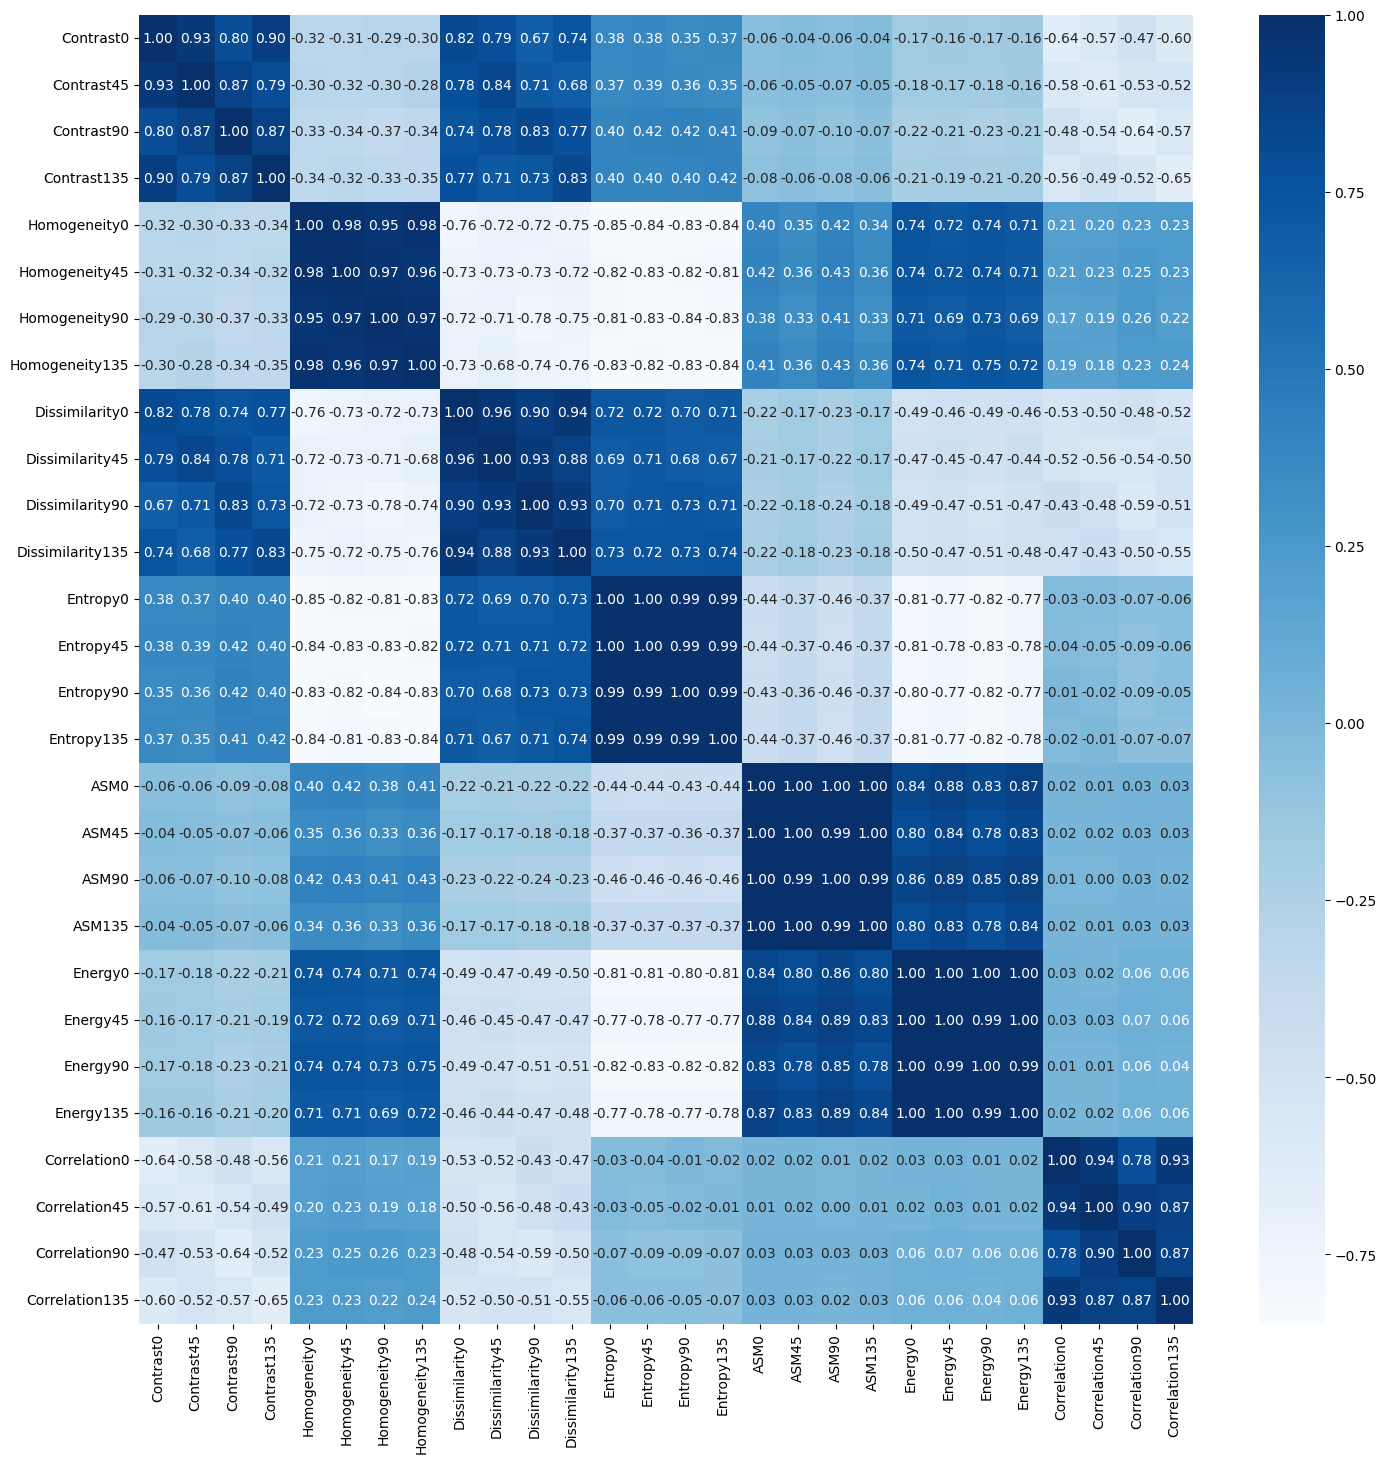

In [202]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 1 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [203]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(462, 28)
(198, 28)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [204]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [205]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [206]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

      benign       0.97      0.95      0.96       239
   malignant       0.95      0.96      0.96       223

    accuracy                           0.96       462
   macro avg       0.96      0.96      0.96       462
weighted avg       0.96      0.96      0.96       462

[[228  11]
 [  8 215]]
Accuracy: 0.9588744588744589

------Testing Set------
              precision    recall  f1-score   support

      benign       0.69      0.62      0.66       121
   malignant       0.49      0.57      0.53        77

    accuracy                           0.60       198
   macro avg       0.59      0.60      0.59       198
weighted avg       0.61      0.60      0.61       198

[[75 46]
 [33 44]]
Accuracy: 0.601010101010101


### Train SVM Classifier

In [207]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

      benign       0.73      0.83      0.78       239
   malignant       0.79      0.66      0.72       223

    accuracy                           0.75       462
   macro avg       0.76      0.75      0.75       462
weighted avg       0.76      0.75      0.75       462

[[199  40]
 [ 75 148]]
Accuracy: 0.7510822510822511

------Testing Set------
              precision    recall  f1-score   support

      benign       0.77      0.79      0.78       121
   malignant       0.66      0.62      0.64        77

    accuracy                           0.73       198
   macro avg       0.71      0.71      0.71       198
weighted avg       0.73      0.73      0.73       198

[[96 25]
 [29 48]]
Accuracy: 0.7272727272727273


### Train KNN Classifier

In [208]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

      benign       0.79      0.80      0.79       239
   malignant       0.78      0.77      0.78       223

    accuracy                           0.79       462
   macro avg       0.79      0.79      0.79       462
weighted avg       0.79      0.79      0.79       462

[[191  48]
 [ 51 172]]
Accuracy: 0.7857142857142857

------Testing Set------
              precision    recall  f1-score   support

      benign       0.79      0.74      0.76       121
   malignant       0.62      0.69      0.65        77

    accuracy                           0.72       198
   macro avg       0.71      0.71      0.71       198
weighted avg       0.72      0.72      0.72       198

[[89 32]
 [24 53]]
Accuracy: 0.7171717171717171


## Evaluation With Confusion Matrix

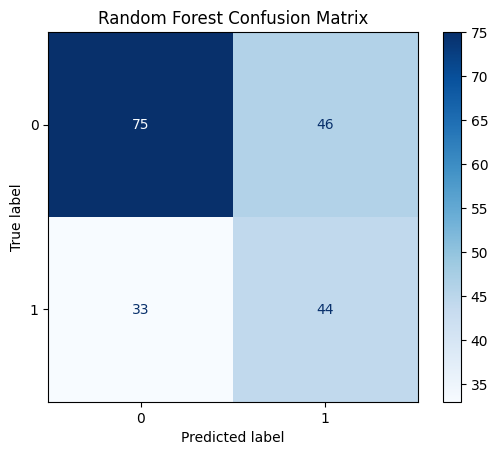

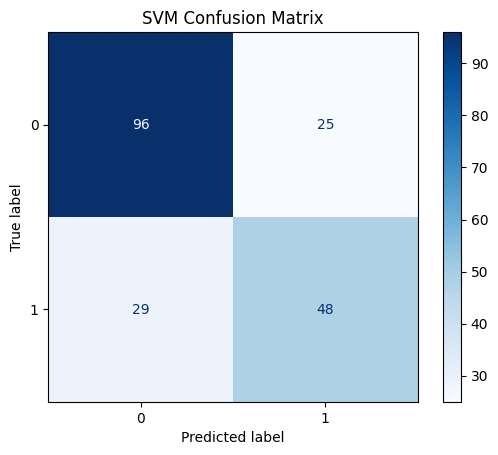

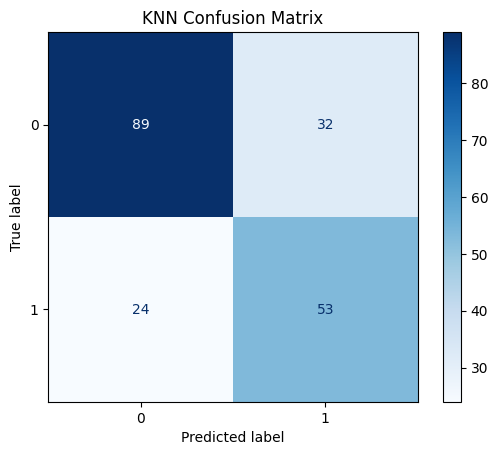

In [209]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")